In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydot --quiet
!pip install mlflow --quiet
!pip install dagshub --quiet
!pip install -q transformers==4.37.2
!pip install "pandas<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.6/226.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata

In [3]:

# import dagshub
# import mlflow
# dagshub.init("w266-final-project", "bho1", mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c4bded0e-2a2f-411f-9fbc-6c03b7982e30&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a1ada686db25d62db0748bac4fa14f4bed09f8cf8c10c1b13b2d82d7edab92bc




Exception: Error while getting OAuth code: HTTP 408, Body: The authorization request was not approved on time - for your security, it was canceled. Please try again.

In [ ]:
# Example
if False:
  mlflow.start_run()

  # train your model...

  mlflow.log_param("parameter name ", "value")
  mlflow.log_metric("metric name", 1)

  mlflow.end_run()

In [4]:
import os
import pickle
import itertools


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model


In [5]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

In [6]:
# brendanho123
# data_path = 'drive/My Drive/Colab Notebooks/W266/Final Project/data'

# bho1
# data_path = 'drive/My Drive/Colab Notebooks/Final Project/data'

# bholly597
data_path = 'drive/My Drive/Final Project/data'

In [7]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [8]:
unpickled_data = {}

keys_to_unpickle = [
    'train_data',
    'test_data',
    'val_data',
]


for key in keys_to_unpickle:
    filename = f'{data_path}/cleaned_data/{key}.pkl'
    with open(filename, 'rb') as file:
        unpickled_data[key] = pickle.load(file)


train_data = unpickled_data['train_data']
test_data = unpickled_data['test_data']
val_data = unpickled_data['val_data']


In [9]:
MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence



num_train_examples = 10000
num_val_examples = 1000


# num_train_examples = 50000
# num_val_examples = 5000

# num_train_examples = train_data.shape[0]
# num_val_examples = test_data.shape[0]


In [10]:
x_train_file_path = f'{data_path}/tokens/x_train_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_val_file_path = f'{data_path}/tokens/x_val_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_test_file_path = f'{data_path}/tokens/x_test_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

# Get train data
if os.path.exists(x_train_file_path):
  x_train = pickle.load(open(x_train_file_path, 'rb'))
else:
  x_train = bert_tokenizer(list(train_data['text'])[:num_train_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')


  with open(x_train_file_path, 'wb') as f:
    pickle.dump(x_train, f)

# Get val data
if os.path.exists(x_val_file_path):
  x_val = pickle.load(open(x_val_file_path, 'rb'))
else:
  x_val = bert_tokenizer(list(val_data['text'])[:num_val_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

  with open(x_val_file_path, 'wb') as f:
    pickle.dump(x_val, f)

# Get test data
if os.path.exists(x_test_file_path):
  x_test = pickle.load(open(x_test_file_path, 'rb'))
else:
  x_test = bert_tokenizer(list(test_data['text'])[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')

  with open(x_test_file_path, 'wb') as f:
    pickle.dump(x_test, f)


y_train = train_data['Overall_score'][:num_train_examples]
y_val = val_data['Overall_score'][:num_val_examples]
y_test = test_data['Overall_score'][:num_val_examples]


In [11]:
# Experiment 2 UIDs specifics here

anime_features_train = train_data['anime_uid'][:num_train_examples]
anime_features_val = val_data['anime_uid'][:num_val_examples]
anime_features_test = test_data['anime_uid'][:num_val_examples]

user_features_train = train_data['profile_uid'][:num_train_examples]
user_features_val = val_data['profile_uid'][:num_val_examples]
user_features_test = test_data['profile_uid'][:num_val_examples]

In [12]:
train_synopsis_file_path = f'{data_path}/tokens/train_synopsis_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
val_synopsis_file_path = f'{data_path}/tokens/val_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
test_synopsis_file_path = f'{data_path}/tokens/test_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

if os.path.exists(train_synopsis_file_path):
  bert_train_synopsis = pickle.load(open(train_synopsis_file_path, 'rb'))
else:
  train_synopsis = train_data['synopsis'].astype(str).tolist()
  bert_train_synopsis = bert_tokenizer(train_synopsis[:num_train_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(train_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_train_synopsis, f)

if os.path.exists(val_synopsis_file_path):
  bert_val_synopsis = pickle.load(open(val_synopsis_file_path, 'rb'))
else:
  val_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_val_synopsis = bert_tokenizer(val_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(val_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_val_synopsis, f)

if os.path.exists(test_synopsis_file_path):
  bert_test_synopsis = pickle.load(open(test_synopsis_file_path, 'rb'))
else:
  test_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_test_synopsis = bert_tokenizer(test_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(test_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_test_synopsis, f)

### Model

In [13]:
# Experiment 2

num_animes = 16216
num_users = 47885

In [14]:
def create_two_tower_model(
    bert_model,
    train_layers=True,
    layers=[70, 50, 20, 10],
    dropout=0.3,
    optimizer_type='adam',
    learning_rate=0.00005,
    loss='mean_absolute_error',
    embedding_size=10, ################### Experiment 2
):

    if not train_layers:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Train all layers of the BERT model
        bert_model.trainable = True

    # Anime Embeddings
    anime_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_input_ids_layer')
    anime_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_token_type_ids_layer')
    anime_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_attention_mask_layer')

    bert_anime_inputs = {
        'input_ids': anime_input_ids,
        'token_type_ids': anime_token_type_ids,
        'attention_mask': anime_attention_mask
    }

    bert_anime_out = bert_model(bert_anime_inputs)

    cls_anime_token = bert_anime_out[0][:, 0, :]

    ###### Experiment 2
    anime_features = tf.keras.layers.Input(shape=(1,), name='anime_features_input')
    anime_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_animes, input_length=num_train_examples, name='anime_emb')(anime_features)
    reshaped_anime_features_embed = tf.squeeze(anime_features_embed, axis=1)

    anime_concatenated_output = tf.keras.layers.Concatenate()([cls_anime_token, reshaped_anime_features_embed])

    # Dense layer to return to the same dimension
    anime_tower_output = tf.keras.layers.Dense(units=768, activation='relu', name='anime_output_layer')(anime_concatenated_output)

    ###### Experiment 2

    # anime_flatten = layers.Flatten(name='flatten_anime')(cls_anime_token)
    anime_model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features], outputs=anime_tower_output)

    # User Embeddings
    user_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_input_ids_layer')
    user_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_token_type_ids_layer')
    user_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_attention_mask_layer')

    bert_user_inputs = {
        'input_ids': user_input_ids,
        'token_type_ids': user_token_type_ids,
        'attention_mask': user_attention_mask
    }

    bert_user_out = bert_model(bert_user_inputs)

    # pooler_user_token = bert_user_out[1]
    cls_user_token = bert_user_out[0][:, 0, :]

    ###### Experiment 2
    user_features = tf.keras.layers.Input(shape=(1,), name='user_features_input')
    user_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_users, input_length=num_train_examples, name='user_emb')(user_features)
    reshaped_user_features_embed = tf.squeeze(user_features_embed, axis=1)
    user_concatenated_output = tf.keras.layers.Concatenate()([cls_user_token, reshaped_user_features_embed])

    # Dense layer to return to the same dimension
    user_tower_output = tf.keras.layers.Dense(units=768, activation='relu', name='user_output_layer')(user_concatenated_output)
    ###### Experiment 2

    # user_flatten = layers.Flatten(name='flatten_user')(cls_user_token)
    user_model = keras.Model(inputs=[user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=user_tower_output)

    # Two Tower Model
    cls_anime_token_reshaped = tf.expand_dims(anime_tower_output, axis=1)
    cls_user_token_reshaped = tf.expand_dims(user_tower_output, axis=2)


    merged =  tf.matmul(cls_anime_token_reshaped, cls_user_token_reshaped)

    dense_layers = []
    dropout_layers = []
    for i, num_layers in enumerate(layers):
      if i == 0:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(merged)
      else:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(dropout_layers[-1])
      dense_layers.append(dense)

      if i != len(layers) - 1:
        dropout_layer = tf.keras.layers.Dropout(dropout, name=f'dropout_{i + 1}')(dense_layers[-1])
        dropout_layers.append(dropout_layer)

    result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_layers[-1])

    if optimizer_type == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_type == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features, user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=result)
    model.compile(optimizer=optimizer, loss=loss)

    return model, anime_model, user_model

### Parameters

In [15]:
param_grid = {
    'train_layers': [True],
    'layers': [[70, 50, 20, 10]],
    'dropout': [0.5],# 0.3],
    'optimizer_type': ['adam'],# 'adamax'],
    'learning_rate': [0.0005],# 0.005],
    'loss': ['mean_absolute_error'],#, 'mean_squared_error'],
}

In [16]:
param_combinations = list(itertools.product(*param_grid.values()))
param_list = [{param_name: params for param_name, params in zip(param_grid.keys(), parameters)} for parameters in param_combinations]
print(f'Number of hyperparameter combinations: {len(param_list)}')
print(param_list[0])

Number of hyperparameter combinations: 1
{'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.5, 'optimizer_type': 'adam', 'learning_rate': 0.0005, 'loss': 'mean_absolute_error'}


In [17]:
# param_list.index({'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.7, 'optimizer_type': 'adamax', 'learning_rate': 0.005, 'loss': 'mean_absolute_error'})

In [18]:
# # Default parameters
# parameters = {
#     'train_layers': True,
#     'layers': [70, 50, 20, 10],
#     'dropout': 0.5,
#     'optimizer_type': 'adam',
#     'learning_rate': 0.00005,
#     'loss': 'mean_absolute_error',
# }

In [19]:
# bert_model = TFBertModel.from_pretrained(checkpoint)
# two_tower_bert_model, anime_model, user_model = create_two_tower_model(bert_model, **parameters)

In [20]:
# two_tower_bert_model.summary()

In [21]:
# keras.utils.plot_model(two_tower_bert_model, show_shapes=True, dpi=90)

In [22]:
track_metrics = False

In [46]:
batch_size = 16
epochs = 30

callback  = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)


for i, parameters in enumerate(param_list):
    print(f'Parameter Set {i}')
    print(parameters)
    bert_model = TFBertModel.from_pretrained(checkpoint)
    two_tower_bert_model, anime_model, user_model = create_two_tower_model(bert_model, **parameters)


    if track_metrics:
      mlflow.start_run()
      mlflow.set_tag("model", "two_tower_bert+uid_review-score_model")

    two_tower_bert_model_history = two_tower_bert_model.fit(
        [
            bert_train_synopsis.input_ids,
            bert_train_synopsis.token_type_ids,
            bert_train_synopsis.attention_mask,
            anime_features_train,  ###### Experiment 2
            x_train.input_ids,
            x_train.token_type_ids,
            x_train.attention_mask,
            user_features_train,  ###### Experiment 2
        ],
        y_train,
        validation_data=(
            [
                bert_val_synopsis.input_ids,
                bert_val_synopsis.token_type_ids,
                bert_val_synopsis.attention_mask,
                anime_features_val,  ###### Experiment 2
                x_val.input_ids,
                x_val.token_type_ids,
                x_val.attention_mask,
                user_features_val,  ###### Experiment 2
            ], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[callback]
    )

    if track_metrics:
      for key, value in parameters.items():
          mlflow.log_param(key, value)


      mlflow.log_param('train_size', num_train_examples)
      mlflow.log_param('val_size', num_val_examples)
      mlflow.log_param('batch_size', batch_size)
      mlflow.log_param('epochs', epochs)
      mlflow.log_param('max_sequence_length', MAX_SEQUENCE_LENGTH)
      mlflow.log_param('run_location', 'colab')

      mlflow.log_metric('epochs_ran', len(two_tower_bert_model_history.history['val_loss']))
      mlflow.log_metric("start train_loss", two_tower_bert_model_history.history['loss'][0])
      mlflow.log_metric("end train_loss", two_tower_bert_model_history.history['loss'][-1])
      mlflow.log_metric("start val_loss", two_tower_bert_model_history.history['val_loss'][0])
      mlflow.log_metric("end val_loss", two_tower_bert_model_history.history['val_loss'][-1])

      mlflow.end_run()

Parameter Set 0
{'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.5, 'optimizer_type': 'adam', 'learning_rate': 0.0005, 'loss': 'mean_absolute_error'}
Epoch 1/30


625/625 [==============================] - 244s 317ms/step - loss: 4.0698 - val_loss: 3.3513
Epoch 2/30
625/625 [==============================] - 178s 285ms/step - loss: 2.9257 - val_loss: 3.6416
Epoch 3/30
625/625 [==============================] - 181s 290ms/step - loss: 2.6058 - val_loss: 3.4012
Epoch 4/30
625/625 [==============================] - 181s 289ms/step - loss: 2.2454 - val_loss: 2.4617
Epoch 5/30
625/625 [==============================] - 181s 289ms/step - loss: 1.9466 - val_loss: 2.1428
Epoch 6/30
625/625 [==============================] - 180s 289ms/step - loss: 1.7320 - val_loss: 2.1556
Epoch 7/30
625/625 [==============================] - 181s 289ms/step - loss: 1.5861 - val_loss: 2.2511
Epoch 8/30
625/625 [==============================] - 181s 290ms/step - loss: 1.4873 - val_loss: 2.1802
Epoch 9/30
625/625 [==============================] - 180s 289ms/step - loss: 1.4156 - val_loss: 2.0956
Epoch 10/30
625/625 [==============================] - 180s 288ms/step - lo

In [24]:
# two_tower_bert_model_history.summary()

In [ ]:
# two_tower_bert_model_history.history['precision_at_k']

In [ ]:
mlflow.end_run()

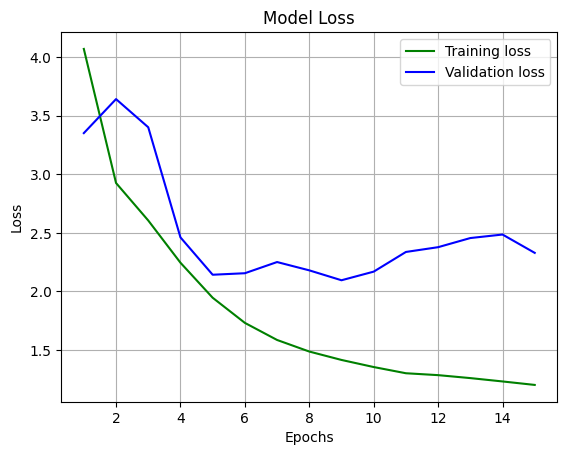

In [47]:
train_loss = two_tower_bert_model_history.history['loss']
val_loss = two_tower_bert_model_history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Movie Embeddings

In [48]:
import pandas as pd
all_data = pd.concat([train_data[:num_train_examples], val_data[:num_val_examples], test_data[:num_val_examples]])
animes = pd.read_csv(f'{data_path}/raw_data/animes_final.csv')

In [49]:
all_anime_ids = all_data['anime_uid'].unique()
all_present_anime_ids = animes[animes['uid'].isin(all_anime_ids)].sort_values(by='popularity')['uid']

In [50]:
unique_anime_ids = all_present_anime_ids[:2000]

anime_id_dict = {id: i for i, id in enumerate(unique_anime_ids)}

print(f'The length of the unique anime ids is {len(unique_anime_ids)}')

The length of the unique anime ids is 2000


In [51]:
anime_recommendation_input_ids = []
anime_recommendation_token_type_ids = []
anime_recommendation_attention_mask = []
anime_recommendation_uids = []
for anime_id in unique_anime_ids:
    try:
      temp_df = train_data.iloc[:num_train_examples].reset_index()
      anime_idx = temp_df.loc[temp_df['anime_uid'] == anime_id].index[0]
      anime_recommendation_input_ids.append(bert_train_synopsis.input_ids[anime_idx])
      anime_recommendation_token_type_ids.append(bert_train_synopsis.token_type_ids[anime_idx])
      anime_recommendation_attention_mask.append(bert_train_synopsis.attention_mask[anime_idx])
    except IndexError:
      try:
        temp_df = val_data.iloc[:num_val_examples].reset_index()
        anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
        anime_recommendation_input_ids.append(bert_val_synopsis.input_ids[anime_idx])
        anime_recommendation_token_type_ids.append(bert_val_synopsis.token_type_ids[anime_idx])
        anime_recommendation_attention_mask.append(bert_val_synopsis.attention_mask[anime_idx])
      except IndexError:
        try:
          temp_df = test_data.iloc[:num_val_examples].reset_index()
          anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
          anime_recommendation_input_ids.append(bert_test_synopsis.input_ids[anime_idx])
          anime_recommendation_token_type_ids.append(bert_test_synopsis.token_type_ids[anime_idx])
          anime_recommendation_attention_mask.append(bert_test_synopsis.attention_mask[anime_idx])
        except IndexError:
          print(f'Could not find index for {anime_id}')
    anime_recommendation_uids.append(anime_id)


In [52]:
input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(anime_recommendation_input_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_token_type_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_attention_mask),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_uids)
),)).batch(len(anime_recommendation_uids))

In [53]:
anime_embeddings = anime_model.predict(input_dataset)

1/1 [==============================] - 8s 8s/step


In [ ]:
def tsne_plot(
    embeddings,
    size=len(anime_embeddings),
    figsize=(20, 20)
):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(embeddings[:size])

    # Store x and y values from T-SNE
    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    # Plot x,y values

    labels = list(range(0,size))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')

    plt.show()
    return new_values

In [ ]:
pca_values = tsne_plot(np.array(anime_embeddings), 100)

### KNN

In [54]:
n_neighbors = 10

In [55]:
# Fit a KNN Clasiffier

clf = KNeighborsClassifier(n_neighbors=n_neighbors+1)
clf.fit(anime_embeddings, unique_anime_ids)

KNeighborsClassifier(n_neighbors=11)

In [56]:
def anime_recommendations(user_embedding, n_neibhors=n_neighbors):
    _, idxs = clf.kneighbors(user_embedding.reshape(1, -1),  n_neighbors=n_neighbors)
    idxs = idxs.reshape(10,1)

    df_indices = pd.DataFrame(idxs, columns = ['anime_uid'])

    return df_indices.merge(animes.rename(columns={'uid': 'anime_uid'}), on='anime_uid', how='inner')['title']

In [57]:
user_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
    tf.data.Dataset.from_tensor_slices(test_data.iloc[:num_val_examples]['profile_uid'])
),)).batch(len(x_test.attention_mask))

In [58]:
user_embeddings = user_model.predict(user_input_dataset)

1/1 [==============================] - 5s 5s/step


In [ ]:
user_embeddings

array([[ 0.04681338,  0.04893781, -0.02201427, ..., -0.04628367,
         0.00331904, -0.01865407],
       [-0.03146454,  0.02828935, -0.02891755, ..., -0.00077809,
        -0.00939655,  0.02761343],
       [ 0.01475233, -0.02007218, -0.03824742, ..., -0.02263149,
        -0.03357561,  0.0426194 ],
       ...,
       [ 0.00143169, -0.04576957,  0.01016546, ..., -0.0421494 ,
        -0.00422215,  0.03576929],
       [ 0.01969547,  0.04542298, -0.03696175, ..., -0.00698883,
        -0.00281409,  0.04097113],
       [-0.02296953,  0.04665759, -0.03345828, ..., -0.02244594,
         0.02713314, -0.03043503]], dtype=float32)

In [ ]:
user_idx = 45

In [ ]:
for i in range(10):
  print(f'User {i} Recommendations:')
  print(anime_recommendations(user_embeddings[i].reshape(1,-1)[0]))

User 0 Recommendations:
0        Mobile Suit Gundam SEED
1          Super Doll Licca-chan
2             Shin Kaitei Gunkan
3           Chou Kuse ni Narisou
4    Denshin Mamotte Shugogetten
5             Witch Hunter Robin
6                    Candy Candy
7                Kaze no Tairiku
8      Nikuyoku Gangu Takuhainin
9        Gakuen Tokusou Hikaruon
Name: title, dtype: object
User 1 Recommendations:
0                           Crayon Shin-chan
1                 Watashi no Ashinaga Ojisan
2            Shakugan no Shana Movie Special
3                            Kaze no Tairiku
4                   Mahoujin Guru Guru Movie
5                                Candy Candy
6                     Akai Kiba: Blue Sonnet
7    Onna Senshi Efe & Jira: Gude no Monshou
8                      NG Knight Ramune & 40
Name: title, dtype: object
User 2 Recommendations:
0                                   Gokinjo Monogatari
1                                        Parade Parade
2                            

### Coverage

In [59]:
selected_test_data = test_data.iloc[:num_val_examples]
unique_profile_ids = selected_test_data['profile_uid'].unique()
print(len(unique_profile_ids))

948


In [60]:
unique_recommendations = set()
unique_recommendation_pairs = set()
total_recommendations = 0
user_recommendations = 0
for i in range(len(user_embeddings)):
  recommendations = anime_recommendations(user_embeddings[i])
  unique_recommendations.update(recommendations.values)
  unique_recommendation_pairs.update([(selected_test_data.iloc[i]['profile_uid'], rec) for rec in recommendations.values])
  total_recommendations += len(recommendations)
  if len(recommendations) > 0:
    user_recommendations += 1



print(f'Unique Recommendations: {len(unique_recommendations)}')
print(f'Unique Recommendation Pairs: {len(unique_recommendation_pairs)}')
print(f'Total Recommendations: {total_recommendations}')
print(f'User Recommendations: {user_recommendations}')

Unique Recommendations: 52
Unique Recommendation Pairs: 8399
Total Recommendations: 8853
User Recommendations: 1000


In [61]:

print(f'Item Coverage: {len(unique_recommendations) / len(unique_anime_ids)}')
print(f'User Coverage: {user_recommendations / num_val_examples}')
print(f'Total Coverage: {len(unique_recommendation_pairs) / (len(unique_anime_ids) * len(unique_profile_ids))}')

Item Coverage: 0.026
User Coverage: 1.0
Total Coverage: 0.004429852320675105


### Precision and Recall at K

In [62]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_r, est in predictions:
        user_est_true[uid].append((est[0], true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [63]:
selected_test_datat = test_data.iloc[:num_val_examples]

In [64]:
prediction_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.input_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.token_type_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.attention_mask),
    tf.data.Dataset.from_tensor_slices(anime_features_test),
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
    tf.data.Dataset.from_tensor_slices(user_features_test),
),)).batch(len(x_test.attention_mask))

model_predictions = two_tower_bert_model.predict(prediction_input_dataset)

1/1 [==============================] - 11s 11s/step


In [65]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: [0.01845992]
Recall@10: [0.01898734]
F1@10: [0.01871991]


In [66]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7.5)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: [0.0021097]
Recall@10: [0.0021097]
F1@10: [0.0021097]


In [67]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=8)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: 0.0
Recall@10: [0.]
F1@10: [nan]


<ipython-input-67-2885a32f2c94>:9: RuntimeWarning: invalid value encountered in divide
  print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')
